### Handling missing values through imputation using Multi_imputation chain equation - random forest - MICE-RF for streamflow

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import warnings
import seaborn as sns
import os

# Suppress convergence warnings 
warnings.filterwarnings("ignore", category=UserWarning, message=".*Early stopping criterion not reached.*")

# Load the dataset 
df = pd.read_csv(
    "monthly_streamflow_original.csv",
    parse_dates=['Date'],
    date_format="%d/%m/%Y" 
)

# Set datetime index and keep only the target column    
df.set_index('Date', inplace=True)
df = df[['streamflow (Mean)']]

In [30]:
print(df.columns.tolist())


['streamflow (Mean)']


### Visualize missing values

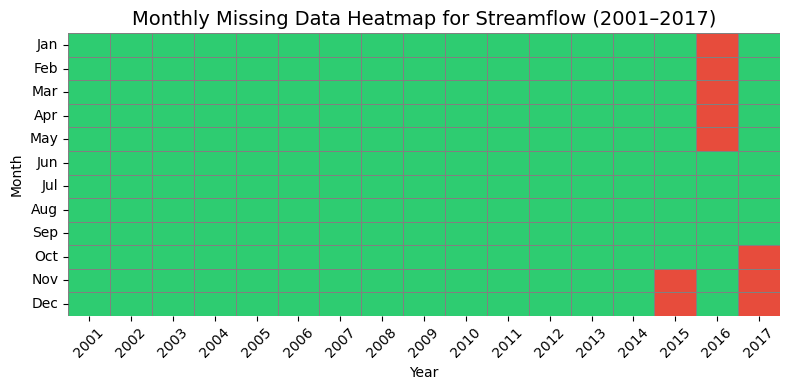

In [31]:

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure index is datetime and monthly
df = df.asfreq('ME')  # Ensures each month is represented

# Create a column indicating missing or not (1 = missing, 0 = present)
missing_indicator = df['streamflow (Mean)'].isna().astype(int)

# Convert to DataFrame for plotting
plot_df = pd.DataFrame({'Missing': missing_indicator})
plot_df['Year'] = plot_df.index.year
plot_df['Month'] = plot_df.index.month_name().str[:3]  # e.g., 'Jan', 'Feb'

# Pivot to Year vs Month table for heatmap
heatmap_data = plot_df.pivot(index='Month', columns='Year', values='Missing')
# Reorder months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data = heatmap_data.reindex(month_order)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    heatmap_data,
    cmap=['#2ecc71', '#e74c3c'],  # Green for present, red for missing
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Monthly Missing Data Heatmap for Streamflow (2001–2017)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()

# Save
output_folder = 'outputs'
os.makedirs(output_folder, exist_ok=True)
plt.savefig(os.path.join(output_folder, 'monthly_missing_streamflow_heatmap.png'), dpi=300)
plt.show()


### Creating lags with seven previous data points

In [32]:
# Create extended lag features to capture temporal integrity
df['streamflow_lag1'] = df['streamflow (Mean)'].shift(1)
df['streamflow_lag2'] = df['streamflow (Mean)'].shift(2)
df['streamflow_lag3'] = df['streamflow (Mean)'].shift(3)
df['streamflow_lag4'] = df['streamflow (Mean)'].shift(4)
df['streamflow_lag5'] = df['streamflow (Mean)'].shift(5)
df['streamflow_lag6'] = df['streamflow (Mean)'].shift(6)
df['streamflow_lag7'] = df['streamflow (Mean)'].shift(7)

### Visualize missing values with Lags - 1 - 7

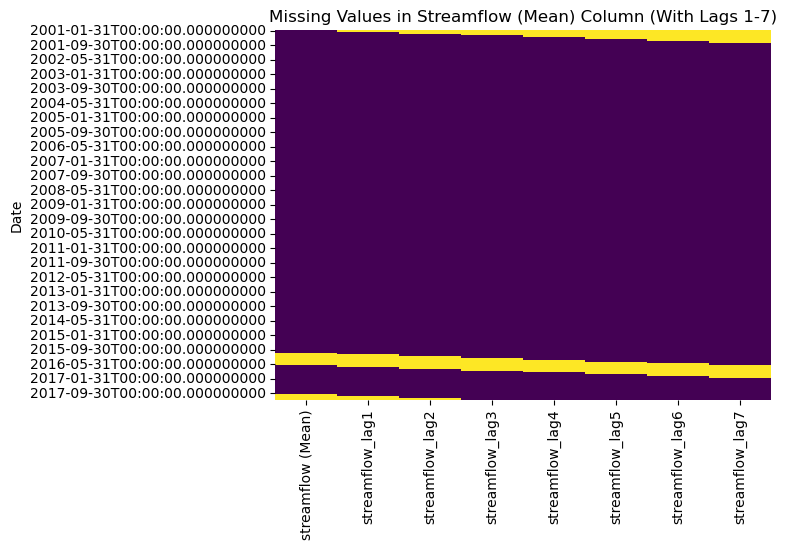

In [33]:
#sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
# plt.title("Missing Values in Streamflow (Mean) Column (With Lags 1-7)")
#plt.show()

sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Streamflow (Mean) Column (With Lags 1-7)")

# Ensure the outputs directory exists
os.makedirs('outputs', exist_ok=True)

# Save the heatmap to file
plt.savefig('outputs/lagged_missingvalues_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()


### Prepare data for imputation using Multi-imputation chain equation with random forest - MICE-RF

In [34]:

df_impute = df.copy()

# Apply MICE with RandomForest (MICE-RF)
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    max_iter=20,
    random_state=42,
    verbose=2
)

# Perform imputation
imputed_array = imputer.fit_transform(df_impute)
df_imputed = pd.DataFrame(imputed_array, columns=df_impute.columns, index=df_impute.index)

# Add the imputed column back to the main DataFrame
df['streamflow (Mean) Imputed'] = df_imputed['streamflow (Mean)']

[IterativeImputer] Completing matrix with shape (204, 8)
[IterativeImputer] Ending imputation round 1/20, elapsed time 1.34
[IterativeImputer] Change: 95.43409985735369, scaled tolerance: 0.1416 
[IterativeImputer] Ending imputation round 2/20, elapsed time 2.75
[IterativeImputer] Change: 32.24300000000002, scaled tolerance: 0.1416 
[IterativeImputer] Ending imputation round 3/20, elapsed time 4.08
[IterativeImputer] Change: 32.494200000000035, scaled tolerance: 0.1416 
[IterativeImputer] Ending imputation round 4/20, elapsed time 5.43
[IterativeImputer] Change: 16.40279999999998, scaled tolerance: 0.1416 
[IterativeImputer] Ending imputation round 5/20, elapsed time 6.72
[IterativeImputer] Change: 15.762100000000004, scaled tolerance: 0.1416 
[IterativeImputer] Ending imputation round 6/20, elapsed time 8.04
[IterativeImputer] Change: 14.7397, scaled tolerance: 0.1416 
[IterativeImputer] Ending imputation round 7/20, elapsed time 9.38
[IterativeImputer] Change: 12.583999999999975, sca

### Plot Visualization - original vs imputed 

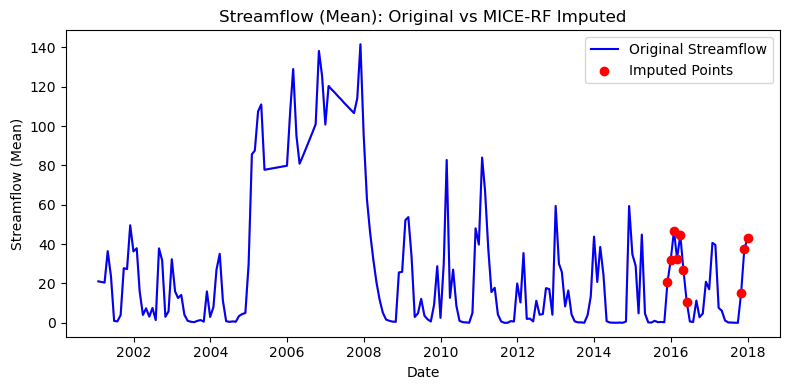

 Imputed streamflow data saved to 'monthly_streamflow_imputed.csv'
 Distribution plot saved to 'imputed\monthly_streamflow_impute_distribution.png'


In [35]:

import matplotlib.pyplot as plt
import os

# Create output folder
output_folder = 'imputed'
os.makedirs(output_folder, exist_ok=True)

# Plot original vs imputed
plt.figure(figsize=(8, 4))

# Original data with NaNs
plt.plot(df.index, df['streamflow (Mean)'], color='orange', alpha=0.5)

# Imputed values
plt.plot(df.index, df['streamflow (Mean) Imputed'], label='Original Streamflow', color='blue')

# Highlight the imputed points
missing_mask = df['streamflow (Mean)'].isna()
plt.scatter(df.index[missing_mask], df['streamflow (Mean) Imputed'][missing_mask],
            color='red', label='Imputed Points', zorder=5)

# Final touches
plt.title('Streamflow (Mean): Original vs MICE-RF Imputed')
plt.xlabel('Date')
plt.ylabel('Streamflow (Mean)')
plt.legend()
plt.tight_layout()

# Save figure before showing it
plot_path = os.path.join(output_folder, 'monthly_streamflow_impute_distribution.png')
plt.savefig(plot_path, dpi=300)

# Show the plot
plt.show()

# Save imputed data to CSV
df_to_save = df[['streamflow (Mean) Imputed']].copy()
df_to_save.reset_index(inplace=True)
df_to_save.to_csv("monthly_streamflow_imputed.csv", index=False)

print(" Imputed streamflow data saved to 'monthly_streamflow_imputed.csv'")
print(f" Distribution plot saved to '{plot_path}'")